In [1]:
import torch
import torchaudio
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)


1.12.0+cu102
0.12.0+cu102


In [2]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import requests
import soundfile as sf
import numpy as np
import math

In [105]:
_SAMPLE_DIR = "_assets"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    result = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
    
    return result


def get_speech_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)


def get_spectrogram(spec=None, n_fft=400, win_len=None, hop_len=None, power=2.0):
    waveform, _ = get_speech_sample()
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
    )
    return spectrogram(waveform)

def get_wav_non_power(spec=None, n_fft=400, win_len=None, hop_len=None) : 
    wav_data = T.InverseSpectrogram(n_fft=n_fft,
                               win_length=win_len,
                               hop_length=hop_len,
                               center=True,
                               pad_mode="reflect",                                
                               )
    return wav_data(spec) 

def get_wav_power(spec=None, n_fft=400, win_len=None, hop_len=None) : 
    wav_data = T.GriffinLim(n_fft=n_fft,
                            win_length=win_len,
                            hop_length=hop_len,                                 
                            )
    return wav_data(spec)


def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [ ]:
voice_file_name = "speech.wav"
voice_file_path = os.path.join("./_assets/", voice_file_name)
    
data, rate = sf.read(voice_file_path)

torch.Size([1, 201, 273])


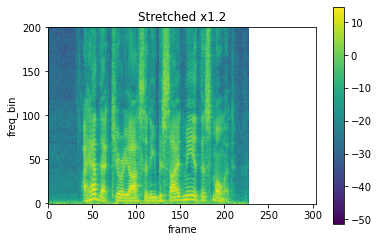

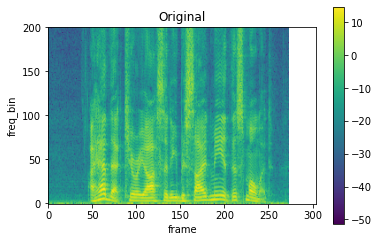

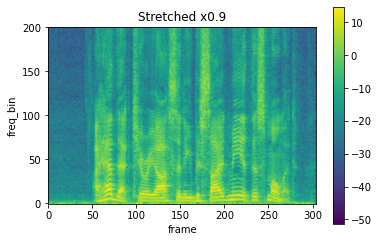

In [63]:
#Time wrap
spec = get_spectrogram(power=None)


stretch = T.TimeStretch()
print(spec.shape)

rate = 1.2
spec_ = stretch(spec, rate)
plot_spectrogram(torch.abs(spec_[0]), title=f"Stretched x{rate}", aspect="equal", xmax=304)

plot_spectrogram(torch.abs(spec[0]), title="Original", aspect="equal", xmax=304)

rate = 0.9
spec_ = stretch(spec, rate)
plot_spectrogram(torch.abs(spec_[0]), title=f"Stretched x{rate}", aspect="equal", xmax=304)

In [135]:
def spec_mask(spec=None, row=1, clm=1):
    new_speech_data = np.zeros(shape=(1,201, 273))
    new_speech_data[0,:,:]= spec
        #row3, clm3 set zero: 과적합 방지
    del_row =(np.random.rand(1)*(201-1)).astype(int)
    for c in del_row:
        new_speech_data[0,c:c+row,:] = np.zeros((1,1,273))

    del_clm =(np.random.rand(1)*(273-1)).astype(int)
    for c in del_clm:
        new_speech_data[0,:,c:c+clm] = np.zeros((1,201, 1))     # if np.zeros((1,130,1)) => error
    return new_speech_data

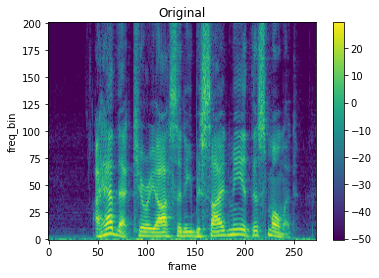

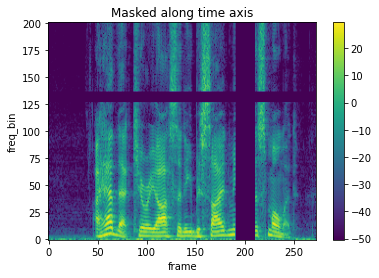

In [138]:
torch.random.manual_seed(4)

spec = get_spectrogram()

plot_spectrogram(spec[0], title="Original")

spec_ = torch.tensor(spec_mask(spec, 10, 20))
plot_spectrogram(spec_[0], title="Masked along time axis")

#Time masking
#masking = T.TimeMasking(time_mask_param=10)
#spec_ = masking(spec)

#plot_spectrogram(spec_[0], title="Masked along time axis")

(tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]]), 16000)


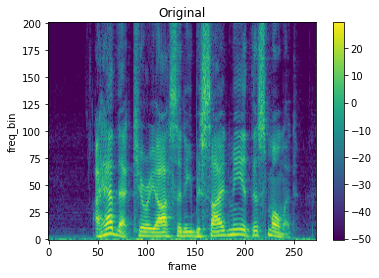

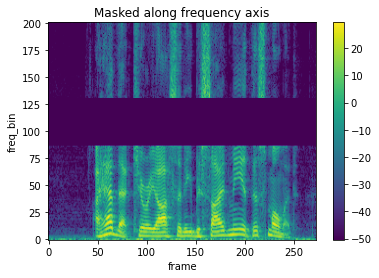

In [11]:
torch.random.manual_seed(4)

spec = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

#Frequency masking
masking = T.FrequencyMasking(freq_mask_param=80)
spec_ = masking(spec)


plot_spectrogram(spec_[0], title="Masked along frequency axis")

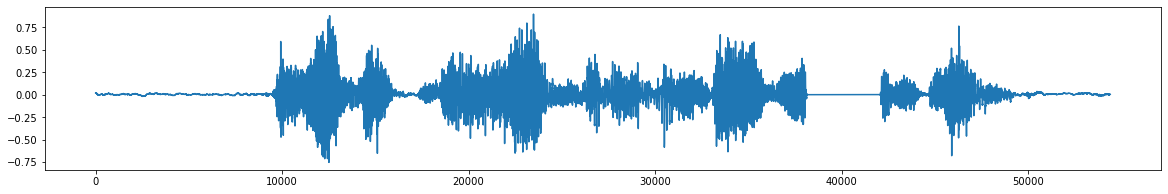

In [154]:
res = get_wav_power(spec=spec_)

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(res[0])

sf.write("./_assets/recovered.wav", res[0], 16000)

(54400,)


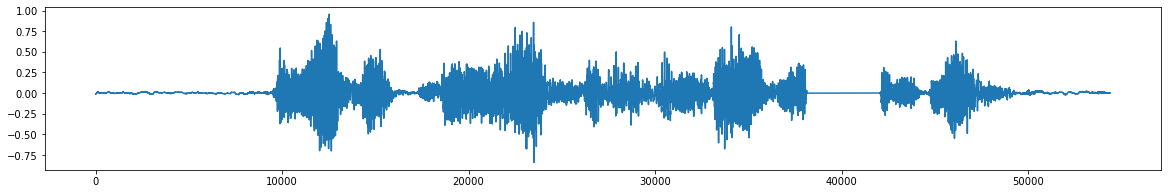

In [140]:
import IPython.display as ipd

voice_file_name = "recovered.wav"
voice_file_path = os.path.join("./_assets/", voice_file_name)
    
data, rate = sf.read(voice_file_path)

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(data)

print(np.shape(data))

ipd.Audio(data, rate=rate, autoplay=True)

(54400,)


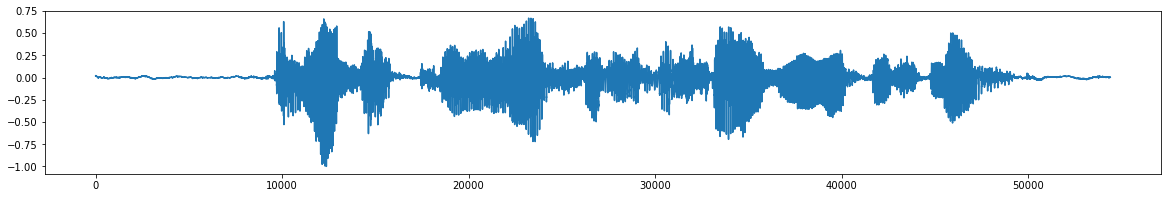

In [141]:
voice_file_name = "speech.wav"
voice_file_path = os.path.join("./_assets/", voice_file_name)
    
data, rate = sf.read(voice_file_path)

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(data)

print(np.shape(data))
ipd.Audio(data, rate=rate, autoplay=True)